<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework7/hw7_201216.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time 

In [2]:
# load data and only use the 'train' part of it
load = tf.keras.datasets.fashion_mnist.load_data()
print("train images",load[0][0].shape)
print("train labels",load[0][1].shape)
print("test images",load[1][0].shape)
print("test labels",load[1][1].shape)

4423680/4422102 [==============================] - 0s 0us/step
train images (60000, 28, 28)
train labels (60000,)
test images (10000, 28, 28)
test labels (10000,)


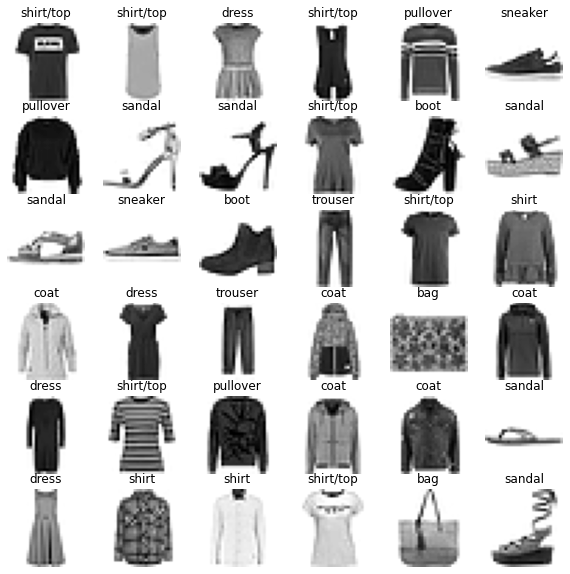

In [3]:
# plot the first entries to get an idea of the data
fig = plt.figure(figsize=(10,10))
class_names={0:'shirt/top',1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker',8:'bag', 9:'boot'}
for i in range(1,37):
  img = load[0][0][i]
  fig.add_subplot(6,6,i)
  
  plt.imshow(img, cmap="gray_r")
  plt.axis('off')  
  # the label is 0 if the image contains malaria and 1 if it does not
  plt.title( str(class_names[int(load[0][1][i])]))

fig.show()

In [4]:
def preprocess_img(image):
  """
  normalize between 0 and 1
  """
  max = tf.math.reduce_max(image)
  min = tf.math.reduce_min(image)
  image = (image - min) / (max - min)
  return image

In [12]:
# Train dataset
ds_train_img = tf.data.Dataset.from_tensor_slices(load[0][0])
ds_train_img = ds_train_img.map(lambda img: preprocess_img(img))
ds_train_label = tf.data.Dataset.from_tensor_slices(load[0][1])
for entry in ds_train_label:
  print(entry)
  break;
ds_train_label = ds_train_label.map(lambda label: tf.one_hot(label, 10))
ds_train = tf.data.Dataset.zip((ds_train_img, ds_train_label))
#ds_train = ds_train.batch(64).shuffle(buffer_size=64)

# test dataset
ds_tst_img = tf.data.Dataset.from_tensor_slices(load[1][0])
ds_tst_img = ds_tst_img.map(lambda img: preprocess_img(img))
ds_tst_label = tf.data.Dataset.from_tensor_slices(load[1][1])
ds_tst_label = ds_tst_label.map(lambda label: tf.one_hot(label, 10))
ds_tst = tf.data.Dataset.zip((ds_tst_img, ds_tst_label))
#ds_tst = ds_tst.batch(64).shuffle(buffer_size=64)

print(ds_train)
print(ds_tst)

tf.Tensor(9, shape=(), dtype=uint8)
<ZipDataset shapes: ((28, 28), (10,)), types: (tf.float32, tf.float32)>
<ZipDataset shapes: ((28, 28), (10,)), types: (tf.float32, tf.float32)>


In [13]:
for entry in ds_train:
  print(entry[1])
  break;

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


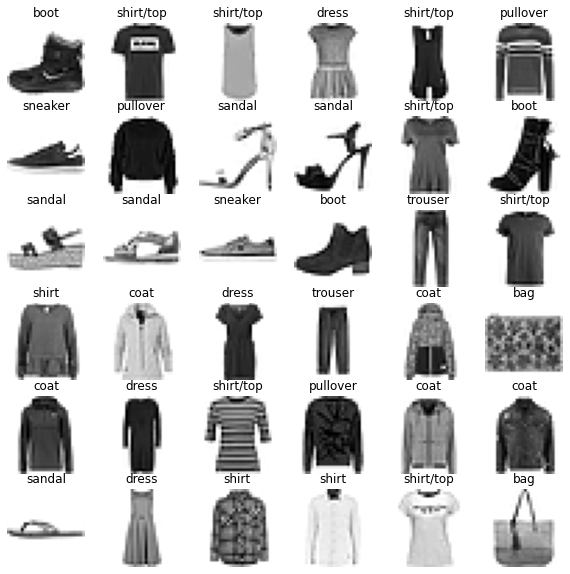

In [16]:
# re-plot the first nine entries after the mapping
def one_hot_to_int(one_hot):
  """
  reverse one hot function returning the int to the one hot vector
  """
  count = 0
  for entry in one_hot:
    if entry:
      break
    count += 1
  return count

count = 0
fig = plt.figure(figsize=(10,10))
#class_names={0:'airplane',1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse',8:'ship', 9:'truck'}
for img in ds_train:
  count += 1
  fig.add_subplot(6,6,count)
  #print(img[0].numpy())
  plt.imshow(img[0], cmap="gray_r")
  plt.axis('off')
  plt.title(class_names[one_hot_to_int(img[1])])
  if count == 36:
    break;
fig.show()

In [17]:
# perf batching, shuffeling and prefetching
train_ds = ds_train.batch(256).shuffle(buffer_size=256).prefetch(4)
test_ds = ds_tst.batch(256).shuffle(buffer_size=256).prefetch(4)

In [18]:
# to check the shape (here: 64 batch size and a 32x32 image with 3 colours)
for (img,_) in test_ds:
    print(img.shape)
    break;

(256, 28, 28)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

class ResidualBlock(layers.Layer):
    def __init__(self, channels):
      super(ResidualBlock, self).__init__()

      self.layer_list = [
        layers.Conv2D(64, kernel_size = 1, activation = None, padding ='same', input_shape=(32,32,channels)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, kernel_size = 3, activation = None, padding ='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(channels, kernel_size = 1, activation = None, padding ='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),

      ]

    def call(self, x, training = False):
      a = tf.identity(x)
      #print("Layers in ResBlock:",len(self.layer_list))
      for layer in self.layer_list:
        #print(x.shape)
        x = layer(x, training = training)
      a = a + x
      return a

class ResNet(Model):

    def __init__(self, residual_blocks = 3):
      super(ResNet, self).__init__()

      self.layer_list = []
      self.layer_list.append(layers.Conv2D(3, kernel_size = 1, activation = None, padding ='same', input_shape=(32,32,3)))
      for i in range(residual_blocks):
        self.layer_list.append(ResidualBlock(3))
      self.layer_list.append(layers.GlobalAveragePooling2D())
      self.layer_list.append(layers.Dense(10,activation=tf.keras.activations.softmax))
    
    def call(self, x, training = False):
      for layer in self.layer_list:
        x = layer(x, training = training)
      return x


In [ ]:
x = tf.ones((256,32,32,3))
block = ResidualBlock(channels = 3)
y = block(x)
print(y.shape)
net = ResNet()
y = net(x)
print(y.shape)

(256, 32, 32, 3)
(256, 10)


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers

class TransitionLayer(Layer):

    def __init__(self, channels, last_trans = False):
        super(TransitionLayer, self).__init__()
        self.layer_list = [
          layers.Conv2D(channels, kernel_size = 1, activation = None, padding ='same'),
          layers.BatchNormalization(),
          layers.Activation('relu'),     
        ]
        if not last_trans:
            self.layer_list.append(layers.AveragePooling2D(strides=(2,2)))

    def call(self, x, training = False):
      for layer in self.layer_list:
        x = layer(x, training = training)
      return x

class ConvBlock(Layer):
    def __init__(self, channels, growth_rate, bottleneck):
      super(ConvBlock, self).__init__()
      self.layer_list = []
      if bottleneck:
        bottleneck_width = 4
        self.layer_list.append(layers.Conv2D(channels * bottleneck_width, kernel_size = 1, activation = None, padding ='same'))
        self.layer_list.append(layers.BatchNormalization())
        self.layer_list.append(layers.Activation('relu'))
      
      self.layer_list.append(layers.Conv2D(channels, kernel_size = 3, activation = None, padding ='same'))
      self.layer_list.append(layers.BatchNormalization())
      self.layer_list.append(layers.Activation('relu'))


    def call(self, x, training = False):
      for layer in self.layer_list:
        x = layer(x, training = training)
      return x

class DenseBlock(Layer):

    def __init__(self, per_block, channels, growth_rate, bottleneck):
        super(DenseBlock, self).__init__()

        self.layer_list = []
        for i in range(per_block):
          self.layer_list.append(ConvBlock(channels, growth_rate, bottleneck))
          channels += growth_rate

    def call(self, x, training = False):

      x_list = [x]
      for layer in self.layer_list:
        temp = layer(x, training = training)
        x_list.append(temp)
        x = layers.concatenate(x_list, axis=-1)
      return x
      


class DenseNet(Model): 
    
    def __init__(self, blocks = 3, per_block = 3, growth_rate = 8, bottleneck = True):
        super(DenseNet, self).__init__()

        channels = growth_rate * 2
        self.layer_list = []
        self.layer_list.append(layers.Conv2D(channels, kernel_size = 3, padding='same'))
        for i in range(blocks):
          self.layer_list.append(DenseBlock(per_block, channels, growth_rate, bottleneck))
          channels += per_block * growth_rate
          if i == blocks - 1:
            self.layer_list.append(TransitionLayer(channels, last_trans=True))
          else:
            self.layer_list.append(TransitionLayer(channels))
        self.layer_list.append(layers.GlobalAveragePooling2D())
        self.layer_list.append(layers.Dense(10,activation=tf.keras.activations.softmax))

    def call(self, x, training = False):
      for layer in self.layer_list:
        x = layer(x, training = training)
      return x
        

In [ ]:
net = DenseNet()
y = net(x)
print(y.shape)

(256, 10)


In [ ]:
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [ ]:
target = np.array([0,0,0,1])
prediction = np.array([0,0,1,0])
sample_test_accuracy = np.argmax(target) == np.argmax(prediction)
sample_test_accuracy = np.mean(sample_test_accuracy)
sample_test_accuracy

0.0

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
#model = DenseNet(growth_rate=4, bottleneck=False)
model = ResNet()
# Using categorical crossentropy due to 10 classes
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(model.summary())
print("Pre-learning")
print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
time0 = time.time()
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)


    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print('train_loss:', round(running_average.numpy(),4),'test_loss:', round(test_loss,4), 'test_acc:', round(test_accuracy,6), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")


Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  12        
_________________________________________________________________
residual_block (ResidualBloc multiple                  75279     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  75279     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  75279     
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  40        
Total params: 225,889
Trainable params: 224,719
Non-trainable params: 1,170
_________________________________________________

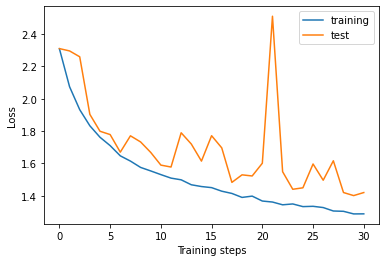

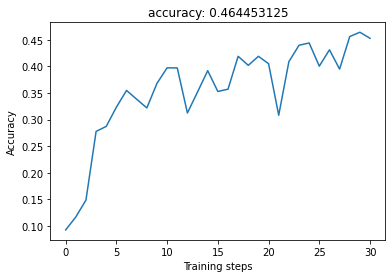

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 60
learning_rate = 0.0005
running_average_factor = 0.95

# Initialize the model.
model = DenseNet(growth_rate=6, bottleneck=False)
#model = ResNet()
# Using categorical crossentropy due to 10 classes
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Using the Adam optimizer with the defined learnig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(model.summary())
print("Pre-learning")
print('test loss:', round(test_loss,4), 'acc:', round(test_accuracy,6))

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
time0 = time.time()
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))
    #time1 = time.time()
    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)


    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    run_time = time.time()-time0 
    print('train_loss:', round(running_average.numpy(),4),'test_loss:', round(test_loss,4), 'test_acc:', round(test_accuracy,6), "running:",round(run_time,1),"sec ETA:",round(((run_time)/(epoch+1)*num_epochs-run_time)/60,1),"min")


Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  336       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  14526     
_________________________________________________________________
transition_layer (Transition multiple                  2130      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  64368     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  6864      
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  149202    
_________________________________________________________________
transition_layer_2 (Transiti multiple                  14

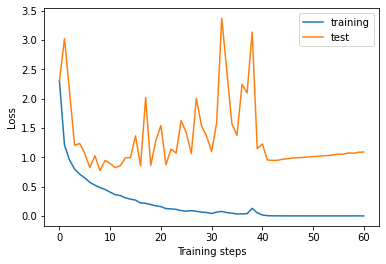

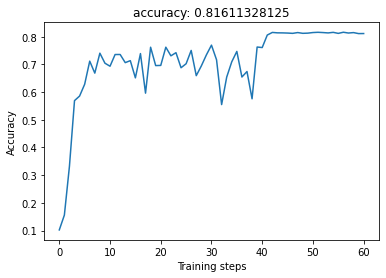

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()